## <font color='red'> NOTE: this notebook is executed on Google Colab

### For this project, we will implement 3 kinds of Variational Autoencoder

* Deep Neural Net VAE
* Convolutional Neural Net VAE
* Residual Neural Net VAE

## 1.1 Download Data

#### We will use the data from https://www.kaggle.com/c/galaxy-zoo-the-galaxy-challenge/data

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%cd /root/
%mkdir .kaggle
%cd .kaggle
!touch kaggle.josn

/root
/root/.kaggle


In [0]:
%cd /content/
%mkdir competitions

/content


In [0]:
# Info on how to get your api key (kaggle.json) here: https://github.com/Kaggle/kaggle-api#api-credentials
api_token = {"username":"shustercao","key":"4ffd10b48136bdd719558ea3285d1651"}
import json
import zipfile
import os
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json
%cd /content/competitions
!kaggle competitions download -c galaxy-zoo-the-galaxy-challenge
os.chdir('/content/competitions/')

zip_ref = zipfile.ZipFile('images_training_rev1.zip', 'r')
zip_ref.extractall()
zip_ref.close()

/content/competitions
100% 1.00G/1.01G [00:35<00:00, 29.9MB/s]
100% 1.01G/1.01G [00:35<00:00, 30.7MB/s]
  0% 0.00/265k [00:00<?, ?B/s]
100% 265k/265k [00:00<00:00, 91.3MB/s]
 98% 777M/792M [00:12<00:00, 117MB/s]
100% 792M/792M [00:12<00:00, 64.0MB/s]
  0% 0.00/4.63M [00:00<?, ?B/s]
100% 4.63M/4.63M [00:00<00:00, 42.6MB/s]
  0% 0.00/265k [00:00<?, ?B/s]
100% 265k/265k [00:00<00:00, 86.5MB/s]
  0% 0.00/520k [00:00<?, ?B/s]
100% 520k/520k [00:00<00:00, 155MB/s]


## 1.2 Data Loading and Preprocessing

In [0]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Subset, Dataset, DataLoader
from torchvision import transforms, utils, datasets

In [0]:
BATCH_SIZE = 10
NUM_TRAIN  = 50000
NUM_TEST   = 5000
NUM_TOTAL  = 61578

TRAIN_DATA_PATH = "/content/competitions/"
TRANSFORM_IMG = transforms.Compose([
    transforms.Resize(320),
    transforms.CenterCrop(256),
    transforms.ToTensor()
    ])

all_data  = datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
indexes   = np.random.choice(NUM_TOTAL, NUM_TRAIN+NUM_TEST, replace=False)
train_ind = indexes[:NUM_TRAIN]
test_ind  = indexes[NUM_TRAIN:]

train_data = Subset(all_data, train_ind)
test_data  = Subset(all_data, test_ind)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [35]:
print(len(train_loader), len(test_loader))

for (i, _) in train_loader:
    print(i.shape)
    break

for (i, _) in test_loader:
    print(i.shape)
    break

5000 500
torch.Size([10, 3, 256, 256])
torch.Size([10, 3, 256, 256])


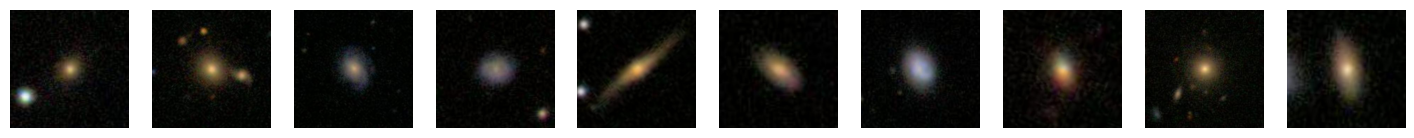

In [36]:
def show_img(images, img_per_row=10):
    IMAGE_NUM = len(images)
    figure = plt.figure(figsize=(18, 16), dpi= 100)
    for index in range(1, IMAGE_NUM + 1):
        plt.subplot(IMAGE_NUM/img_per_row, img_per_row, index)
        plt.axis('off')
        plt.imshow(images[index-1].numpy().transpose((1, 2, 0)))

show_img(i)

## 1.3 Variantional Autoencoder Implementation

### 1.3.1 Deep Neural Net VAE

For DNN-VAE, we will use input size of $3\times 100\times 100$ for sake of efficiency

#### 1.3.1.1 Loading Data

In [0]:
import os
import torch
import pandas as pd
from skimage import io, transform, img_as_float
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Subset, Dataset, DataLoader
from torchvision import transforms, utils, datasets
%matplotlib inline

In [0]:
BATCH_SIZE = 10
NUM_TRAIN  = 7000  # DNN is slower than CNN so we will decrease the number of inputs
NUM_TEST   = 3000
NUM_TOTAL  = 61578

TRAIN_DATA_PATH = "/content/competitions/"
TRANSFORM_IMG = transforms.Compose([
    transforms.Resize(150),
    transforms.CenterCrop(100),
    transforms.ToTensor()
    ])

all_data  = datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
indexes   = np.random.choice(NUM_TOTAL, NUM_TRAIN+NUM_TEST, replace=False)
train_ind = indexes[:NUM_TRAIN]
test_ind  = indexes[NUM_TRAIN:]

train_data = Subset(all_data, train_ind)
test_data  = Subset(all_data, test_ind)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [0]:
print(len(train_loader), len(test_loader))

for (i, _) in train_loader:
    print(i.shape)
    break

for (i, _) in test_loader:
    print(i.shape)
    break

700 300
torch.Size([10, 3, 100, 100])
torch.Size([10, 3, 100, 100])


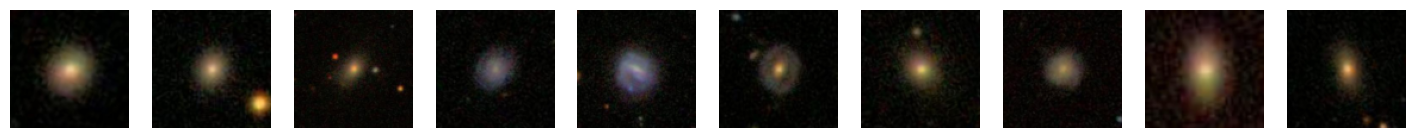

In [0]:
def show_img(images, img_per_row=10):
    IMAGE_NUM = len(images)
    figure = plt.figure(figsize=(18, 16), dpi= 100)
    for index in range(1, IMAGE_NUM + 1):
        plt.subplot(IMAGE_NUM/img_per_row, img_per_row, index)
        plt.axis('off')
        plt.imshow(images[index-1].numpy().transpose((1, 2, 0)))

for i, (img, _) in enumerate(train_loader):
    show_img(img)
    break

#### 1.3.1.2 Build the Model

In [0]:
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable

In [0]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def forward(self, input, height=100, width=100, channel=3):
        return input.view(input.size(0), channel, height, width)

class EncoderDNNBlock(nn.Module):
    def __init__(self, input_channel, output_channel, debug=False):
        super(EncoderDNNBlock, self).__init__()
        self.debug = debug

        self.block = nn.Sequential(
            nn.Linear(input_channel, output_channel),
            nn.BatchNorm1d(output_channel),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.block(x)
        if self.debug:
            print(x.shape)
        return x

class DecoderDNNBlock(nn.Module):
    def __init__(self, input_channel, output_channel, debug=False):
        super(DecoderDNNBlock, self).__init__()
        self.debug = debug

        self.block = nn.Sequential(
            nn.Linear(input_channel, output_channel),
            nn.BatchNorm1d(output_channel),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.block(x)
        if self.debug:
            print(x.shape)
        return x

class DNN_VAE(nn.Module):
    def __init__(self, input_channel=3, zdim=512, height=100, width=100, debug=False):
        super(DNN_VAE, self).__init__()

        self.encoders = nn.Sequential(
            Flatten(),
            EncoderDNNBlock(input_channel*height*width, zdim*16, debug=debug),
            EncoderDNNBlock(zdim*16, zdim*4, debug=debug),
        )

        self.fc1 = nn.Linear(zdim*4, zdim)
        self.fc2 = nn.Linear(zdim*4, zdim)

        self.decoders = nn.Sequential(
            DecoderDNNBlock(zdim, zdim*4, debug=debug),
            DecoderDNNBlock(zdim*4, zdim*16, debug=debug),
            DecoderDNNBlock(zdim*16, input_channel*height*width, debug=debug),
            UnFlatten()
        )

    def sample(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x, Train=True):
        x = self.encoders(x)

        if Train:
            mu = self.fc1(x)
            logvar = self.fc2(x)
            x = self.sample(mu, logvar)
        else:
            x = self.fc1(x)
            mu = None
            logvar = None

        x = self.decoders(x)
        return x, mu, logvar

#### <font color='blue'> We will use $\beta-$VAE with $\beta=0.001$

In [0]:
recon_loss_func = nn.BCELoss()
beta = 0.001

def vae_loss(recon, x, mu, logvar):
    recon_loss = recon_loss_func(recon, x)
    KL_loss = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp()).mean()
    loss = recon_loss + beta * KL_loss
    return loss

In [0]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
    device = torch.device("cuda:0")
else:
    print("No GPU detected")
    device = "cpu"

vae = DNN_VAE().to(device)

Tesla P100-PCIE-16GB


#### 1.3.1.3 Model Training

In [0]:
lrate = 0.01
epochs = 30
train_losses = []
train_batches = len(train_loader)   # this is equal to total_images/batch_size = 7000/10 = 700

In [0]:
from tqdm.autonotebook import tqdm
from time import time
ROOT_DIR = "/content/drive/My Drive/VAE/"

for epoch in range(epochs):
    if epoch % 10 == 0:
        lrate /= 2
        optimizer = torch.optim.Adam(vae.parameters(), lr=lrate, betas=(0.5, 0.999))

    start_ts = time()
    total_loss = 0
    # progress bar
    progress = tqdm(enumerate(train_loader), desc="Loss: ", total=train_batches)
    vae.train() # set model to training
    
    for i, data in progress:
        X = data[0].to(device)
        recon_data, mu, logvar = vae(X)

        loss = vae_loss(recon_data, data[0].to(device), mu, logvar)
        # training step for single batch
        vae.zero_grad()
        loss.backward()
        optimizer.step()

        # getting training quality data
        current_loss = loss.item()
        total_loss += current_loss

        # updating progress bar
        progress.set_description("Loss: {:.4f}".format(current_loss))
        # progress.set_description("Loss: {:.4f}".format(total_loss/(i+1)))

    # releasing unceseccary memory in GPU
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    if epoch % 10 == 9:
        torch.save(vae.state_dict(), ROOT_DIR+"DNN_VAE"+str(epoch+1)+".pt")
        print(f"Model saved successfully for epoch {epoch+1}")

    train_losses.append(total_loss/train_batches)
    print(f"=============== Epoch {epoch+1}/{epochs} ===============")
    print(f"training loss: {total_loss/train_batches:.4f}, training time: {time()-start_ts}s")
    print()


=============== Epoch 1/30 ===============
training loss: 137144.4672, training time: 111.35339045524597s




=============== Epoch 2/30 ===============
training loss: 0.2049, training time: 111.2836000919342s




=============== Epoch 3/30 ===============
training loss: 14.3869, training time: 111.42156624794006s




=============== Epoch 4/30 ===============
training loss: 0.1919, training time: 111.30022549629211s




=============== Epoch 5/30 ===============
training loss: 0.3121, training time: 111.2694263458252s




=============== Epoch 6/30 ===============
training loss: 0.3127, training time: 111.78284311294556s




=============== Epoch 7/30 ===============
training loss: 0.1903, training time: 111.77839231491089s




=============== Epoch 8/30 ===============
training loss: 0.1954, training time: 111.10798788070679s




=============== Epoch 9/30 ===============
training loss: 10033092.4769, training time: 111.69072103500366s




Model saved successfully for epoch 10
=============== Epoch 10/30 ===============
training loss: 0.2046, training time: 185.25332927703857s




=============== Epoch 11/30 ===============
training loss: 0.1826, training time: 112.70120930671692s




=============== Epoch 12/30 ===============
training loss: 0.1815, training time: 111.15456032752991s




=============== Epoch 13/30 ===============
training loss: 0.1811, training time: 111.37280058860779s




=============== Epoch 14/30 ===============
training loss: 0.1807, training time: 111.71997690200806s




=============== Epoch 15/30 ===============
training loss: 0.1806, training time: 111.81805276870728s




=============== Epoch 16/30 ===============
training loss: 0.1802, training time: 111.35700464248657s




=============== Epoch 17/30 ===============
training loss: 0.1801, training time: 111.23952889442444s




=============== Epoch 18/30 ===============
training loss: 0.1800, training time: 111.88168740272522s




=============== Epoch 19/30 ===============
training loss: 0.1798, training time: 112.12322902679443s




Model saved successfully for epoch 20
=============== Epoch 20/30 ===============
training loss: 0.1796, training time: 179.05836868286133s




=============== Epoch 21/30 ===============
training loss: 0.1794, training time: 112.33171939849854s




=============== Epoch 22/30 ===============
training loss: 0.1794, training time: 111.60739374160767s




=============== Epoch 23/30 ===============
training loss: 0.1793, training time: 112.24984192848206s




=============== Epoch 24/30 ===============
training loss: 0.1792, training time: 111.24073052406311s




=============== Epoch 25/30 ===============
training loss: 0.1793, training time: 111.4940676689148s




=============== Epoch 26/30 ===============
training loss: 0.1792, training time: 116.0102207660675s




=============== Epoch 27/30 ===============
training loss: 0.1791, training time: 115.91156148910522s




=============== Epoch 28/30 ===============
training loss: 0.1791, training time: 110.90894389152527s




=============== Epoch 29/30 ===============
training loss: 0.1791, training time: 111.25244736671448s




Model saved successfully for epoch 30
=============== Epoch 30/30 ===============
training loss: 0.1789, training time: 186.77238750457764s



Text(0, 0.5, 'Training Loss')

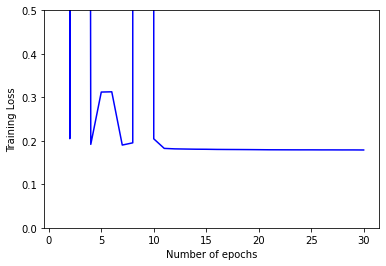

In [0]:
epoches = [i+1 for i in range(epochs)]
plt.plot(epoches, train_losses, 'b-')
plt.ylim((0,0.5))
plt.xlabel('Number of epochs')
plt.ylabel('Training Loss')

#### 1.3.1.4 Results Visualization

Reconstruction for Training Data (Above are true images and below are recostructed images)


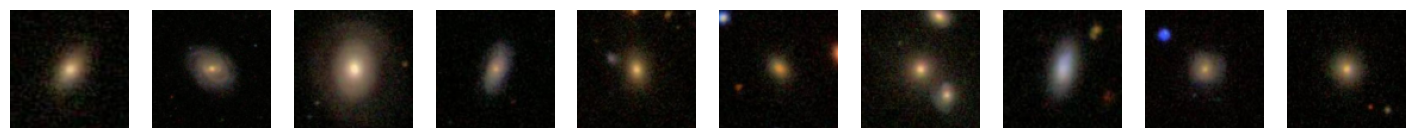

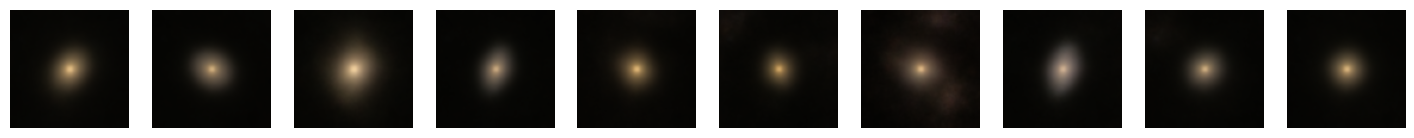

In [0]:
print("Reconstruction for Training Data (Above are true images and below are recostructed images)")
vae.eval()
with torch.no_grad():
    for data in train_loader:
        X = data[0].to(device)
        outputs, _, _ = vae(X, Train=False)
        show_img(X.cpu())
        show_img(outputs.cpu())

        break

Reconstruction for Test Data (Above are true images and below are recostructed images)


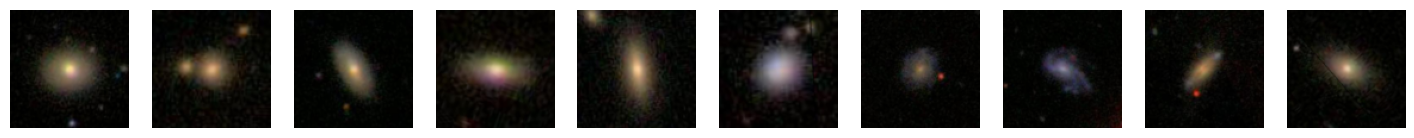

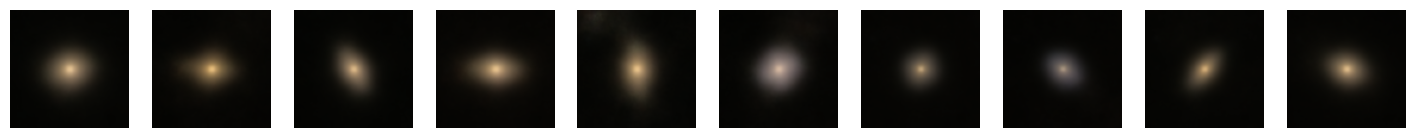

In [0]:
print("Reconstruction for Test Data (Above are true images and below are recostructed images)")
vae.eval()
with torch.no_grad():
    for data in test_loader:
        X = data[0].to(device)
        outputs, _, _ = vae(X, Train=False)
        show_img(X.cpu())
        show_img(outputs.cpu())

        break

Reconstruction for Training Data (Above are true images and below are recostructed images)


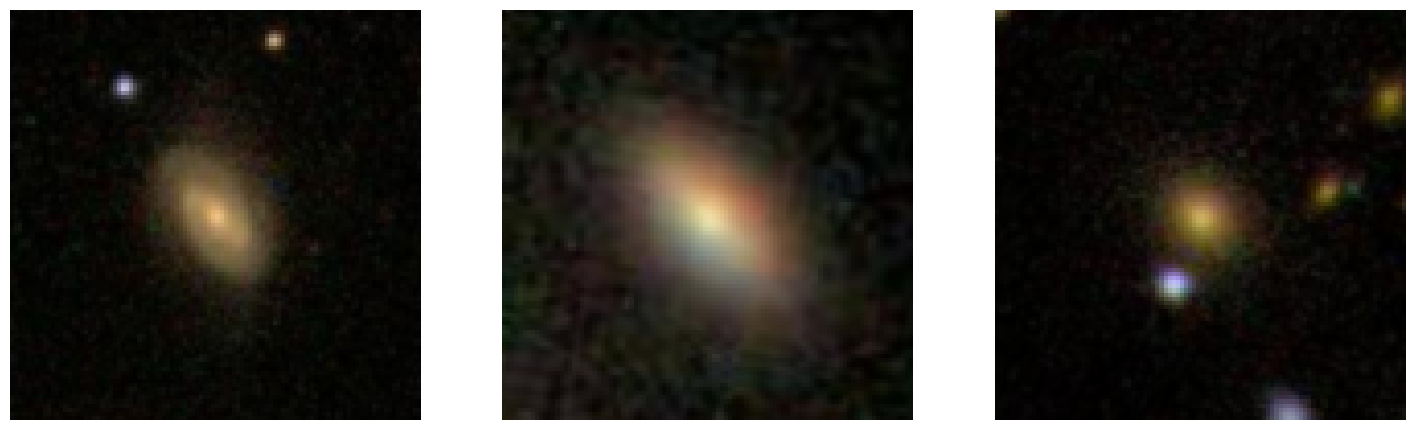

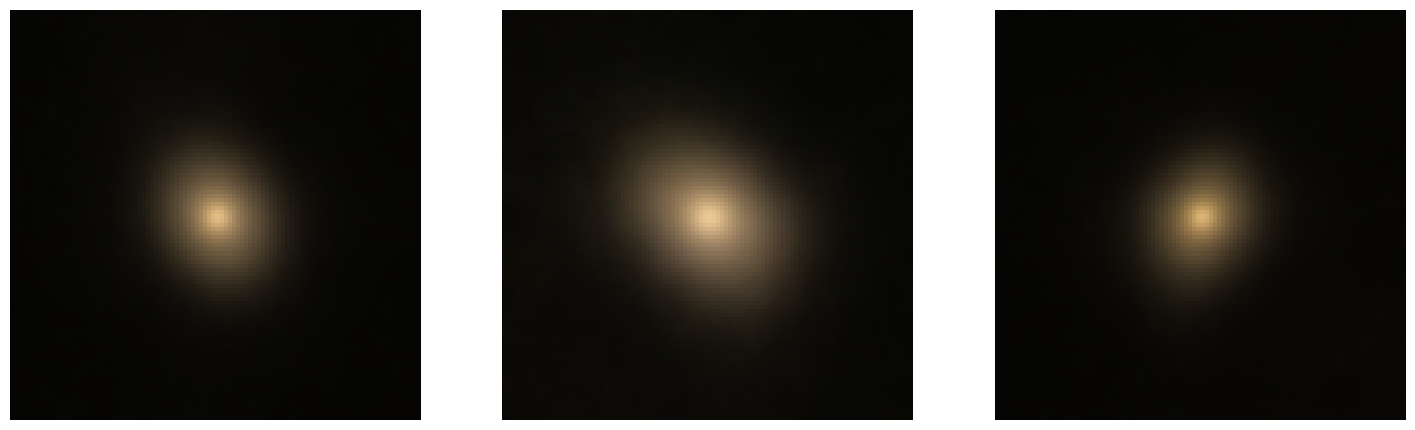

In [0]:
# Larger pictures
print("Reconstruction for Training Data (Above are true images and below are recostructed images)")
vae.eval()
with torch.no_grad():
    for data in train_loader:
        X = data[0].to(device)
        outputs, _, _ = vae(X, Train=False)
        show_img(X.cpu()[:3], img_per_row=3)
        show_img(outputs.cpu()[:3], img_per_row=3)

        break

Reconstruction for Test Data (Above are true images and below are recostructed images)


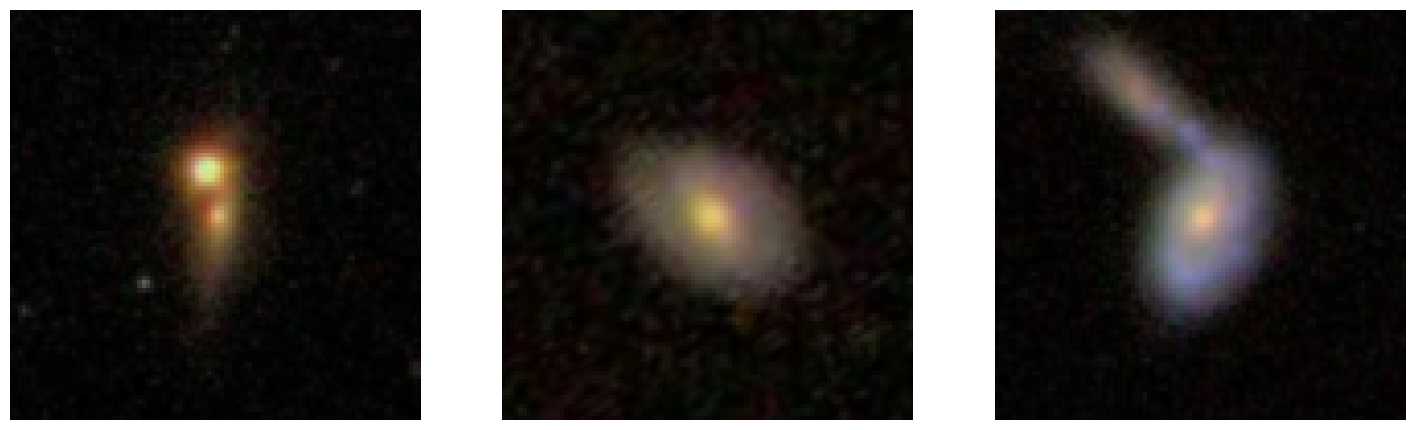

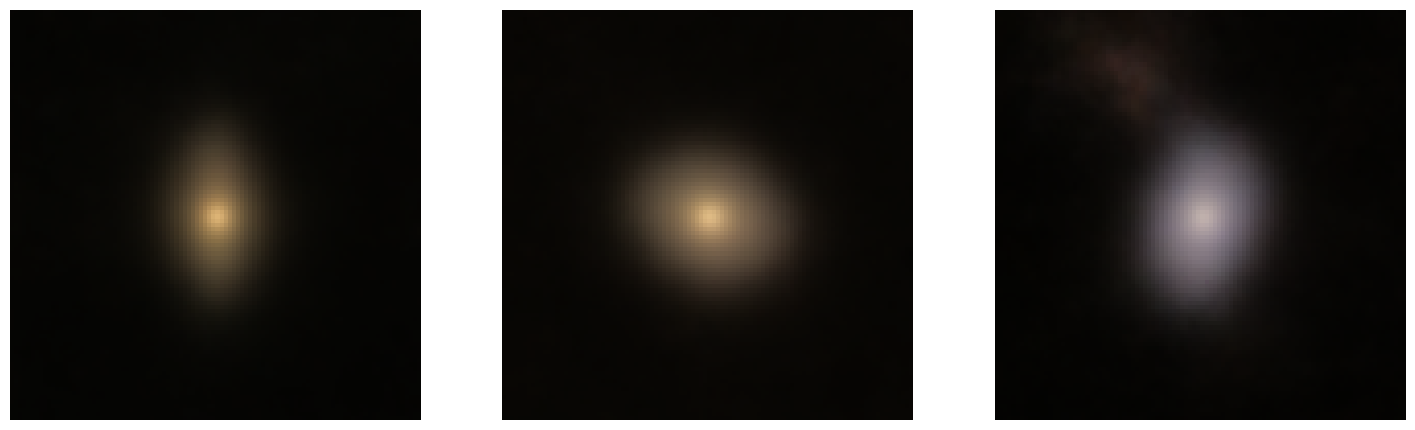

In [0]:
# Larger pictures
print("Reconstruction for Test Data (Above are true images and below are recostructed images)")
vae.eval()
with torch.no_grad():
    for data in test_loader:
        X = data[0].to(device)
        outputs, _, _ = vae(X, Train=False)
        show_img(X.cpu()[:3], img_per_row=3)
        show_img(outputs.cpu()[:3], img_per_row=3)

        break

#### 1.3.1.5 Save Model

In [0]:
torch.save(vae.state_dict(), "/content/drive/My Drive/VAE/best_DNN_VAE.pt")

### 1.3.2 CNN VAE

#### 1.3.2.1 Loading Data

In [0]:
BATCH_SIZE = 10
NUM_TRAIN  = 50000
NUM_TEST   = 5000
NUM_TOTAL  = 61578

TRAIN_DATA_PATH = "/content/competitions/"
TRANSFORM_IMG = transforms.Compose([
    transforms.Resize(320),
    transforms.CenterCrop(256),
    transforms.ToTensor()
    ])

all_data  = datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
indexes   = np.random.choice(NUM_TOTAL, NUM_TRAIN+NUM_TEST, replace=False)
train_ind = indexes[:NUM_TRAIN]
test_ind  = indexes[NUM_TRAIN:]

train_data = Subset(all_data, train_ind)
test_data  = Subset(all_data, test_ind)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

#### 1.3.2.2 Build the Model

In [0]:
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms 
from torch.autograd import Variable

In [0]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def forward(self, input, size=512):
        return input.view(input.size(0), size, 1, 1)

class EncoderCNNBlock(nn.Module):
    def __init__(self, input_channel, output_channel, kernel_size=3, stride=1, padding=1, debug=False):
        super(EncoderCNNBlock, self).__init__()
        self.debug = debug

        self.block = nn.Sequential(
            nn.Conv2d(input_channel, output_channel, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(output_channel),
            nn.LeakyReLU(0.1),
            nn.AvgPool2d(2,2),
        )

    def forward(self, x):
        x = self.block(x)
        if self.debug:
            print(x.shape)
        return x


class DecoderCNNBlock(nn.Module):
    def __init__(self, input_channel, output_channel, kernel_size=3, stride=1, padding=1, debug=False):
        super(DecoderCNNBlock, self).__init__()
        self.debug = debug

        self.block = nn.Sequential(
            nn.ConvTranspose2d(input_channel, output_channel, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(output_channel),
            nn.LeakyReLU(0.1),
            nn.Upsample(scale_factor = 2),
        )

    def forward(self, x):
        x = self.block(x)
        if self.debug:
            print(x.shape)
        return x

class CNN_VAE(nn.Module):
    def __init__(self, input_channel=3, zdim=512, debug=False):
        super(CNN_VAE, self).__init__()

        self.encoders = nn.Sequential(
            EncoderCNNBlock(input_channel, zdim//16, kernel_size=4, stride=2, debug=debug), # [BATCH_SIZE, 32, 64, 64]
            EncoderCNNBlock(zdim//16, zdim//8, kernel_size=4, stride=2, debug=debug),       # [BATCH_SIZE, 64, 16, 16]
            EncoderCNNBlock(zdim//8, zdim//4, kernel_size=4, stride=2, debug=debug),        # [BATCH_SIZE, 128, 4, 4]
            EncoderCNNBlock(zdim//4, zdim//2, debug=debug),                                 # [BATCH_SIZE, 256, 2, 2]
            EncoderCNNBlock(zdim//2, zdim, debug=debug),                                    # [BATCH_SIZE, 512, 1, 1]
            Flatten()
        )

        self.fc1 = nn.Linear(zdim, zdim)
        self.fc2 = nn.Linear(zdim, zdim)

        self.decoders = nn.Sequential(
            UnFlatten(),
            DecoderCNNBlock(zdim, zdim//2, debug=debug),                                    # [BATCH_SIZE, 256, 2, 2]
            DecoderCNNBlock(zdim//2, zdim//4, debug=debug),                                 # [BATCH_SIZE, 128, 4, 4]
            DecoderCNNBlock(zdim//4, zdim//8, kernel_size=4, stride=2, debug=debug),        # [BATCH_SIZE, 64, 16, 16]
            DecoderCNNBlock(zdim//8, zdim//16, kernel_size=4, stride=2, debug=debug),       # [BATCH_SIZE, 32, 64, 64]
            DecoderCNNBlock(zdim//16, input_channel, kernel_size=4, stride=2, debug=debug)  # [BATCH_SIZE, 3, 256, 256]
        )

        self.output = nn.Sigmoid()

    def sample(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x, Train=True):
        x = self.encoders(x)

        if Train:
            mu = self.fc1(x)
            logvar = self.fc2(x)
            x = self.sample(mu, logvar)
        else:
            x = self.fc1(x)
            mu = None
            logvar = None

        x = self.decoders(x)
        x = self.output(x)
        return x, mu, logvar

#### <font color='blue'> We will use $\beta-$VAE with $\beta=0.001$

In [0]:
recon_loss_func = nn.BCELoss()
beta = 0.001

def vae_loss(recon, x, mu, logvar):
    recon_loss = recon_loss_func(recon, x)
    KL_loss = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp()).mean()
    loss = recon_loss + beta * KL_loss
    return loss

In [0]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
    device = torch.device("cuda:0")
else:
    print("No GPU detected")
    device = "cpu"

vae = CNN_VAE().to(device)

Tesla P100-PCIE-16GB


#### 1.3.2.3 Model Training

In [0]:
lrate = 0.02
epochs = 30
train_losses = []
train_batches = len(train_loader)   # this is equal to total_images/batch_size = 7000/10 = 700

In [0]:
from tqdm.autonotebook import tqdm
from time import time
ROOT_DIR = "/content/drive/My Drive/VAE/"

for epoch in range(epochs):
    if epoch % 10 == 0:
        lrate /= 2
        optimizer = torch.optim.Adam(vae.parameters(), lr=lrate, betas=(0.5, 0.999))

    start_ts = time()
    total_loss = 0
    # progress bar
    progress = tqdm(enumerate(train_loader), desc="Loss: ", total=train_batches)
    vae.train() # set model to training
    
    for i, data in progress:
        X = data[0].to(device)
        recon_data, mu, logvar = vae(X)

        loss = vae_loss(recon_data, data[0].to(device), mu, logvar)
        # training step for single batch
        vae.zero_grad()
        loss.backward()
        optimizer.step()

        # getting training quality data
        current_loss = loss.item()
        total_loss += current_loss

        # updating progress bar
        progress.set_description("Loss: {:.4f}".format(current_loss))
        # progress.set_description("Loss: {:.4f}".format(total_loss/(i+1)))

    # releasing unceseccary memory in GPU
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    if epoch % 10 == 9:
        torch.save(vae.state_dict(), ROOT_DIR+"CNN_VAE"+str(epoch+1)+".pt")
        print(f"Model saved successfully for epoch {epoch+1}")

    train_losses.append(total_loss/train_batches)
    print(f"=============== Epoch {epoch+1}/{epochs} ===============")
    print(f"training loss: {total_loss/train_batches:.4f}, training time: {time()-start_ts}s")
    print()


=============== Epoch 1/30 ===============
training loss: 0.3211, training time: 415.5556333065033s




=============== Epoch 2/30 ===============
training loss: 0.1587, training time: 411.32158374786377s




=============== Epoch 3/30 ===============
training loss: 0.1550, training time: 410.0157549381256s




=============== Epoch 4/30 ===============
training loss: 0.1545, training time: 412.4873058795929s




=============== Epoch 5/30 ===============
training loss: 0.1543, training time: 420.8409013748169s




=============== Epoch 6/30 ===============
training loss: 0.1541, training time: 421.20444917678833s




=============== Epoch 7/30 ===============
training loss: 0.1539, training time: 426.19802808761597s




=============== Epoch 8/30 ===============
training loss: 0.1537, training time: 418.4524269104004s




=============== Epoch 9/30 ===============
training loss: 0.1536, training time: 419.70605087280273s




Model saved successfully for epoch 10
=============== Epoch 10/30 ===============
training loss: 0.1535, training time: 418.67014503479004s




=============== Epoch 11/30 ===============
training loss: 0.1532, training time: 424.72359323501587s




=============== Epoch 12/30 ===============
training loss: 0.1532, training time: 430.0116219520569s




=============== Epoch 13/30 ===============
training loss: 0.1531, training time: 423.38720083236694s




=============== Epoch 14/30 ===============
training loss: 0.1530, training time: 411.824835062027s




=============== Epoch 15/30 ===============
training loss: 0.1530, training time: 406.9135653972626s




=============== Epoch 16/30 ===============
training loss: 0.1530, training time: 406.3511085510254s




=============== Epoch 17/30 ===============
training loss: 0.1529, training time: 408.9648628234863s




=============== Epoch 18/30 ===============
training loss: 0.1529, training time: 424.4348301887512s




=============== Epoch 19/30 ===============
training loss: 0.1529, training time: 423.6502962112427s




Model saved successfully for epoch 20
=============== Epoch 20/30 ===============
training loss: 0.1528, training time: 422.1969475746155s




=============== Epoch 21/30 ===============
training loss: 0.1527, training time: 420.81813192367554s




=============== Epoch 22/30 ===============
training loss: 0.1527, training time: 418.8197479248047s




=============== Epoch 23/30 ===============
training loss: 0.1526, training time: 413.76347732543945s




=============== Epoch 24/30 ===============
training loss: 0.1526, training time: 414.86398124694824s




=============== Epoch 25/30 ===============
training loss: 0.1526, training time: 415.62009596824646s




=============== Epoch 26/30 ===============
training loss: 0.1526, training time: 415.2707951068878s




=============== Epoch 27/30 ===============
training loss: 0.1526, training time: 417.1202075481415s




=============== Epoch 28/30 ===============
training loss: 0.1526, training time: 413.375257730484s




=============== Epoch 29/30 ===============
training loss: 0.1526, training time: 414.3416790962219s




Model saved successfully for epoch 30
=============== Epoch 30/30 ===============
training loss: 0.1525, training time: 411.38489866256714s



Text(0, 0.5, 'Training Loss')

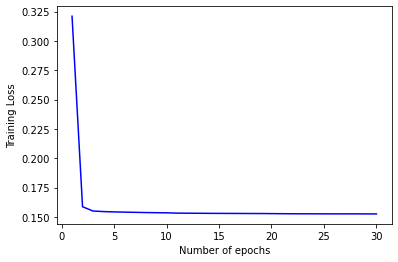

In [0]:
epoches = [i+1 for i in range(epochs)]
plt.plot(epoches, train_losses, 'b-')
plt.xlabel('Number of epochs')
plt.ylabel('Training Loss')

#### 1.3.2.4 Results Visualization

Reconstruction for Training Data (Above are true images and below are recostructed images)


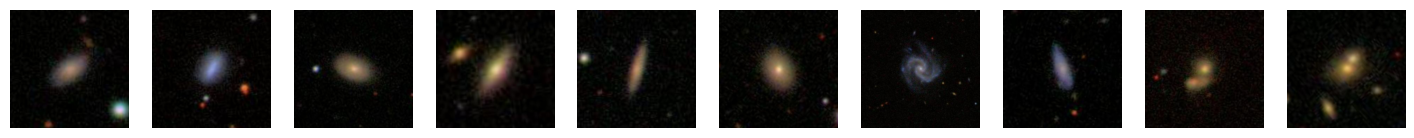

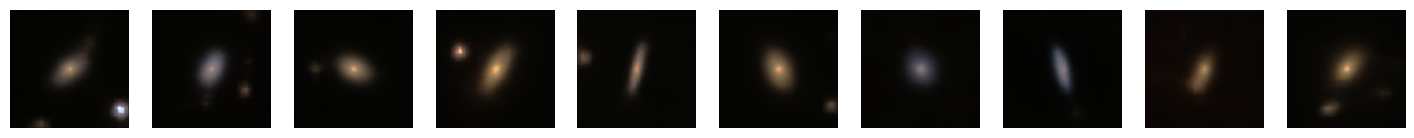

In [0]:
print("Reconstruction for Training Data (Above are true images and below are recostructed images)")
vae.eval()
with torch.no_grad():
    for data in train_loader:
        X = data[0].to(device)
        outputs, _, _ = vae(X, Train=False)
        show_img(X.cpu())
        show_img(outputs.cpu())

        break

Reconstruction for Test Data (Above are true images and below are recostructed images)


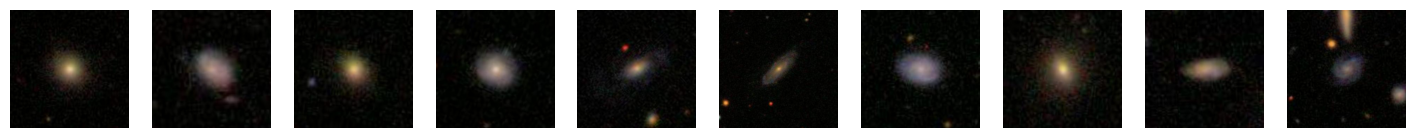

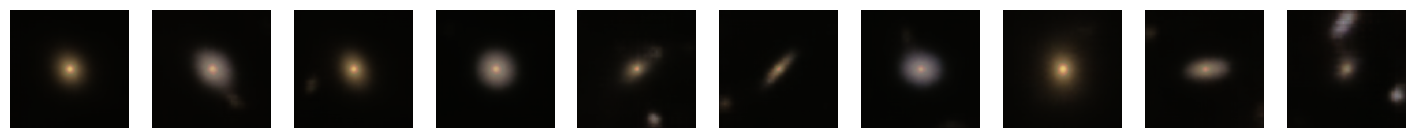

In [0]:
print("Reconstruction for Test Data (Above are true images and below are recostructed images)")
vae.eval()
with torch.no_grad():
    for data in test_loader:
        X = data[0].to(device)
        outputs, _, _ = vae(X, Train=False)
        show_img(X.cpu())
        show_img(outputs.cpu())

        break

Reconstruction for Training Data (Above are true images and below are recostructed images)


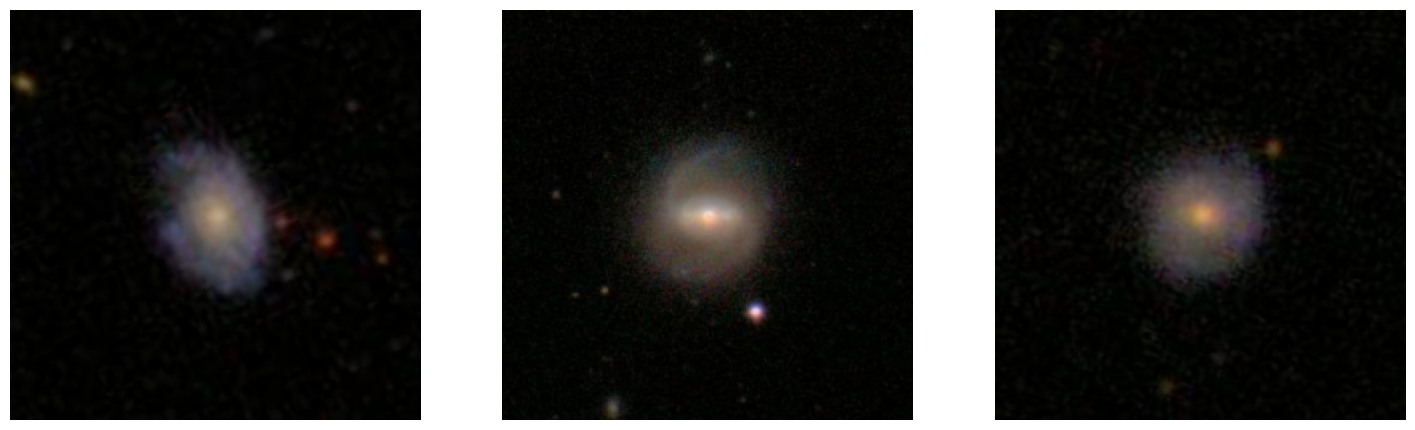

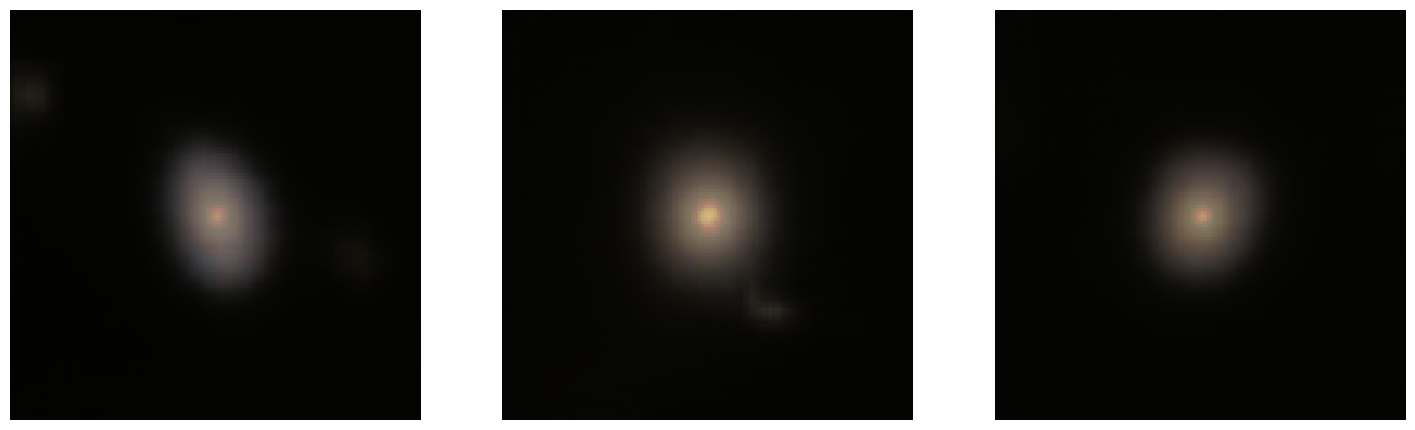

In [0]:
# Larger pictures
print("Reconstruction for Training Data (Above are true images and below are recostructed images)")
vae.eval()
with torch.no_grad():
    for data in train_loader:
        X = data[0].to(device)
        outputs, _, _ = vae(X, Train=False)
        show_img(X.cpu()[:3], img_per_row=3)
        show_img(outputs.cpu()[:3], img_per_row=3)

        break

Reconstruction for Test Data (Above are true images and below are recostructed images)


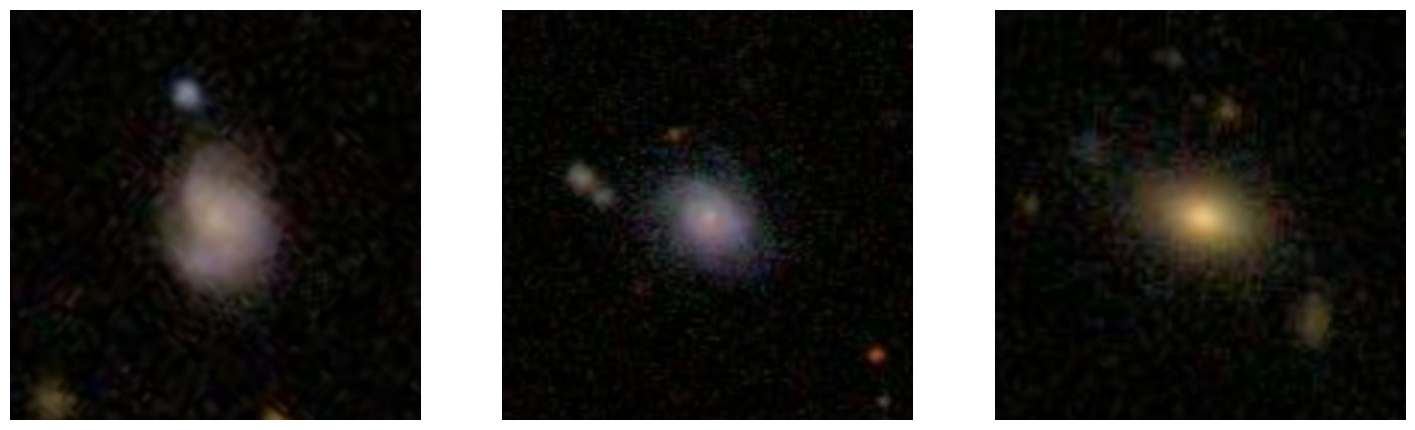

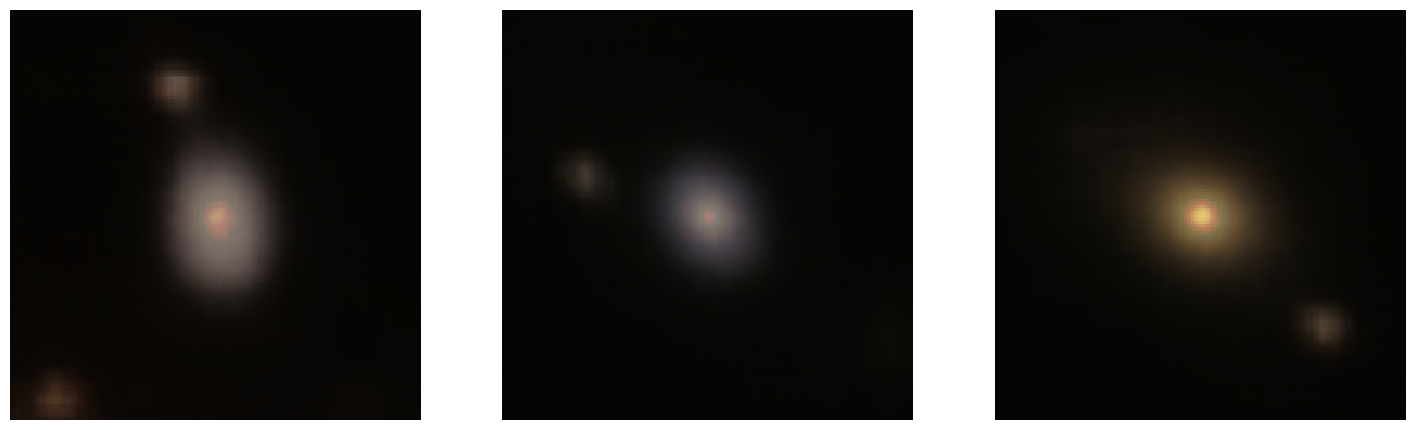

In [0]:
# Larger pictures
print("Reconstruction for Test Data (Above are true images and below are recostructed images)")
vae.eval()
with torch.no_grad():
    for data in test_loader:
        X = data[0].to(device)
        outputs, _, _ = vae(X, Train=False)
        show_img(X.cpu()[:3], img_per_row=3)
        show_img(outputs.cpu()[:3], img_per_row=3)

        break

#### 1.3.2.5 Save Model

In [0]:
torch.save(vae.state_dict(), "/content/drive/My Drive/VAE/best_CNN_VAE.pt")

### 1.3.3 ResNet VAE

#### 1.3.3.1 Loading Data

In [0]:
BATCH_SIZE = 10
NUM_TRAIN  = 50000
NUM_TEST   = 5000
NUM_TOTAL  = 61578

TRAIN_DATA_PATH = "/content/competitions/"
TRANSFORM_IMG = transforms.Compose([
    transforms.Resize(320),
    transforms.CenterCrop(256),
    transforms.ToTensor()
    ])

all_data  = datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
indexes   = np.random.choice(NUM_TOTAL, NUM_TRAIN+NUM_TEST, replace=False)
train_ind = indexes[:NUM_TRAIN]
test_ind  = indexes[NUM_TRAIN:]

train_data = Subset(all_data, train_ind)
test_data  = Subset(all_data, test_ind)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

#### 1.3.3.2 Build the Model

In [0]:
import torch
import torch.nn as nn

In [0]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def forward(self, input, size=512):
        return input.view(input.size(0), size, 1, 1)

# This block will decrease the image size by 2
class EncoderResBlock2x(nn.Module):
    def __init__(self, in_channels, out_channels, debug=False):
        super().__init__()
        self.debug = debug
        self.in_channels, self.out_channels =  in_channels, out_channels
        self.blocks = nn.Sequential(
            nn.Conv2d(in_channels, out_channels//2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels//2),
            nn.LeakyReLU(0.1),

            nn.Conv2d(out_channels//2, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1),
        )
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels)
        )
        self.pooling = nn.AvgPool2d(2, 2)
    
    def forward(self, x):
        residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        x = self.pooling(x)
        if self.debug:
            print(x.shape)
        return x

# This block will decrease the image size by 4
class EncoderResBlock4x(nn.Module):
    def __init__(self, in_channels, out_channels, debug=False):
        super().__init__()
        self.debug = debug
        self.in_channels, self.out_channels =  in_channels, out_channels
        self.blocks = nn.Sequential(
            nn.Conv2d(in_channels, out_channels//2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_channels//2),
            nn.LeakyReLU(0.1),

            nn.Conv2d(out_channels//2, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1),
        )
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_channels)
        )
        self.pooling = nn.AvgPool2d(2, 2)
    
    def forward(self, x):
        residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        x = self.pooling(x)
        if self.debug:
            print(x.shape)
        return x


class DecoderCNNBlock(nn.Module):
    def __init__(self, input_channel, output_channel, kernel_size=3, stride=1, padding=1, debug=False):
        super(DecoderCNNBlock, self).__init__()
        self.debug = debug

        self.block = nn.Sequential(
            nn.ConvTranspose2d(input_channel, output_channel, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(output_channel),
            nn.LeakyReLU(0.1),
            nn.Upsample(scale_factor = 2),
        )

    def forward(self, x):
        x = self.block(x)
        if self.debug:
            print(x.shape)
        return x

class RES_VAE(nn.Module):
    def __init__(self, input_channel=3, zdim=512, debug=False):
        super(RES_VAE, self).__init__()

        self.encoders = nn.Sequential(
            EncoderResBlock4x(input_channel, zdim//16, debug=debug),                          # [BATCH_SIZE, 32, 64, 64]
            EncoderResBlock4x(zdim//16, zdim//8, debug=debug),                                # [BATCH_SIZE, 64, 16, 16]
            EncoderResBlock4x(zdim//8, zdim//4, debug=debug),                                 # [BATCH_SIZE, 128, 4, 4]
            EncoderResBlock2x(zdim//4, zdim//2, debug=debug),                                 # [BATCH_SIZE, 256, 2, 2]
            EncoderResBlock2x(zdim//2, zdim, debug=debug),                                    # [BATCH_SIZE, 512, 1, 1]
            Flatten()
        )

        self.fc1 = nn.Linear(zdim, zdim)
        self.fc2 = nn.Linear(zdim, zdim)

        self.decoders = nn.Sequential(
            UnFlatten(),
            DecoderCNNBlock(zdim, zdim//2, debug=debug),                                    # [BATCH_SIZE, 256, 2, 2]
            DecoderCNNBlock(zdim//2, zdim//4, debug=debug),                                 # [BATCH_SIZE, 128, 4, 4]
            DecoderCNNBlock(zdim//4, zdim//8, kernel_size=4, stride=2, debug=debug),        # [BATCH_SIZE, 64, 16, 16]
            DecoderCNNBlock(zdim//8, zdim//16, kernel_size=4, stride=2, debug=debug),       # [BATCH_SIZE, 32, 64, 64]
            DecoderCNNBlock(zdim//16, input_channel, kernel_size=4, stride=2, debug=debug)  # [BATCH_SIZE, 3, 256, 256]
        )

        self.output = nn.Sigmoid()

    def sample(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x, Train=True):
        x = self.encoders(x)

        if Train:
            mu = self.fc1(x)
            logvar = self.fc2(x)
            x = self.sample(mu, logvar)
        else:
            x = self.fc1(x)
            mu = None
            logvar = None

        x = self.decoders(x)
        x = self.output(x)
        return x, mu, logvar

#### <font color='blue'> We will use $\beta-$VAE with $\beta=0.001$

In [0]:
recon_loss_func = nn.BCELoss()
beta = 0.001

def vae_loss(recon, x, mu, logvar):
    recon_loss = recon_loss_func(recon, x)
    KL_loss = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp()).mean()
    loss = recon_loss + beta * KL_loss
    return loss

In [0]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
    device = torch.device("cuda:0")
else:
    print("No GPU detected")
    device = "cpu"

vae = RES_VAE().to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-2, betas=(0.5, 0.999))

Tesla P100-PCIE-16GB


#### 1.3.3.3 Model Training

In [0]:
lrate = 0.004
epochs = 30
train_losses = []
train_batches = len(train_loader)   # this is equal to total_images/batch_size = 7000/10 = 700

In [0]:
from tqdm.autonotebook import tqdm
from time import time
ROOT_DIR = "/content/drive/My Drive/VAE/"

for epoch in range(epochs):
    if epoch % 10 == 0:
        lrate /= 2
        optimizer = torch.optim.Adam(vae.parameters(), lr=lrate, betas=(0.5, 0.999))

    start_ts = time()
    total_loss = 0
    # progress bar
    progress = tqdm(enumerate(train_loader), desc="Loss: ", total=train_batches)
    vae.train() # set model to training
    
    for i, data in progress:
        X = data[0].to(device)
        recon_data, mu, logvar = vae(X)

        loss = vae_loss(recon_data, data[0].to(device), mu, logvar)
        # training step for single batch
        vae.zero_grad()
        loss.backward()
        optimizer.step()

        # getting training quality data
        current_loss =  loss.item()
        total_loss += current_loss

        # updating progress bar
        progress.set_description("Loss: {:.4f}".format(current_loss))
        # progress.set_description("Loss: {:.4f}".format(total_loss/(i+1)))

    # releasing unceseccary memory in GPU
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    if epoch % 10 == 9:
        torch.save(vae.state_dict(), ROOT_DIR+"RES_VAE"+str(epoch+1)+".pt")
        print(f"Model saved successfully for epoch {epoch+1}")

    train_losses.append(total_loss/train_batches)
    print(f"=============== Epoch {epoch+1}/{epochs} ===============")
    print(f"training loss: {total_loss/train_batches:.4f}, training time: {time()-start_ts}s")
    print()


=============== Epoch 1/30 ===============
training loss: 0.5539, training time: 511.5283191204071s




=============== Epoch 2/30 ===============
training loss: 0.3159, training time: 517.4208760261536s




=============== Epoch 3/30 ===============
training loss: 0.2049, training time: 513.4629235267639s




=============== Epoch 4/30 ===============
training loss: 0.1648, training time: 512.6562938690186s




=============== Epoch 5/30 ===============
training loss: 0.1552, training time: 513.3811028003693s



Buffered data was truncated after reaching the output size limit.

Text(0, 0.5, 'Training Loss')

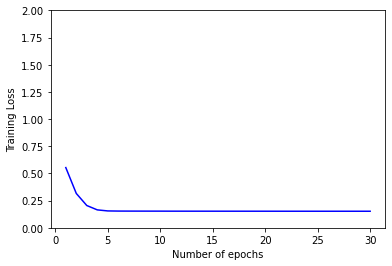

In [0]:
epoches = [i+1 for i in range(epochs)]
plt.plot(epoches, train_losses, 'b-')
plt.ylim((0,2))
plt.xlabel('Number of epochs')
plt.ylabel('Training Loss')

#### 1.3.3.4 Results Visualization

Reconstruction for Training Data (Above are true images and below are recostructed images)


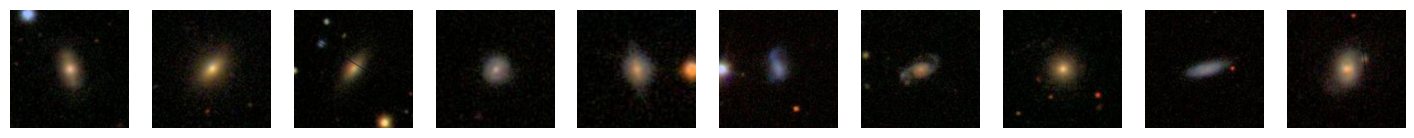

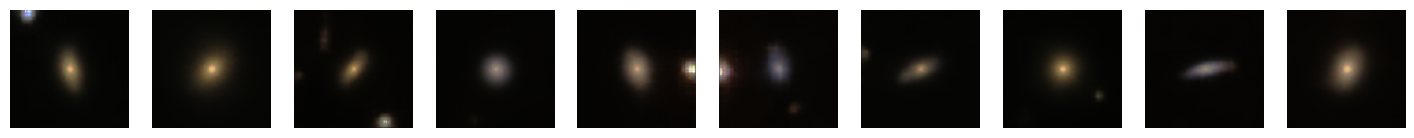

In [0]:
print("Reconstruction for Training Data (Above are true images and below are recostructed images)")
vae.eval()
with torch.no_grad():
    for data in train_loader:
        X = data[0].to(device)
        outputs, _, _ = vae(X, Train=False)
        show_img(X.cpu())
        show_img(outputs.cpu())

        break

Reconstruction for Test Data (Above are true images and below are recostructed images)


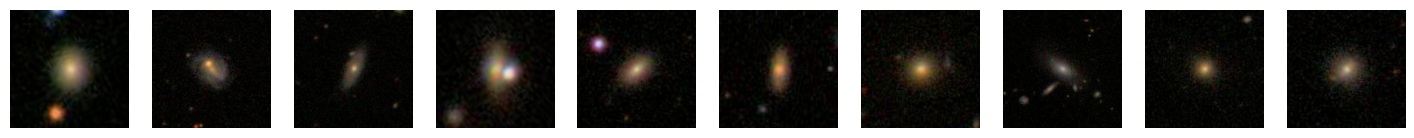

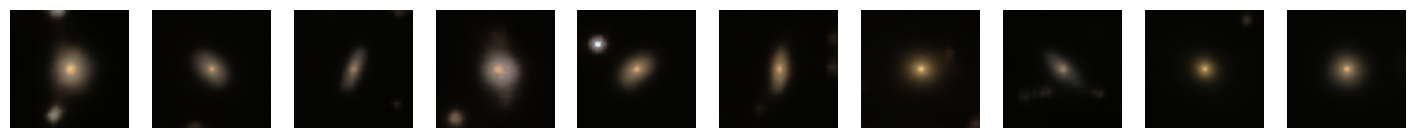

In [0]:
print("Reconstruction for Test Data (Above are true images and below are recostructed images)")
vae.eval()
with torch.no_grad():
    for data in test_loader:
        X = data[0].to(device)
        outputs, _, _ = vae(X, Train=False)
        show_img(X.cpu())
        show_img(outputs.cpu())

        break

Reconstruction for Training Data (Above are true images and below are recostructed images)


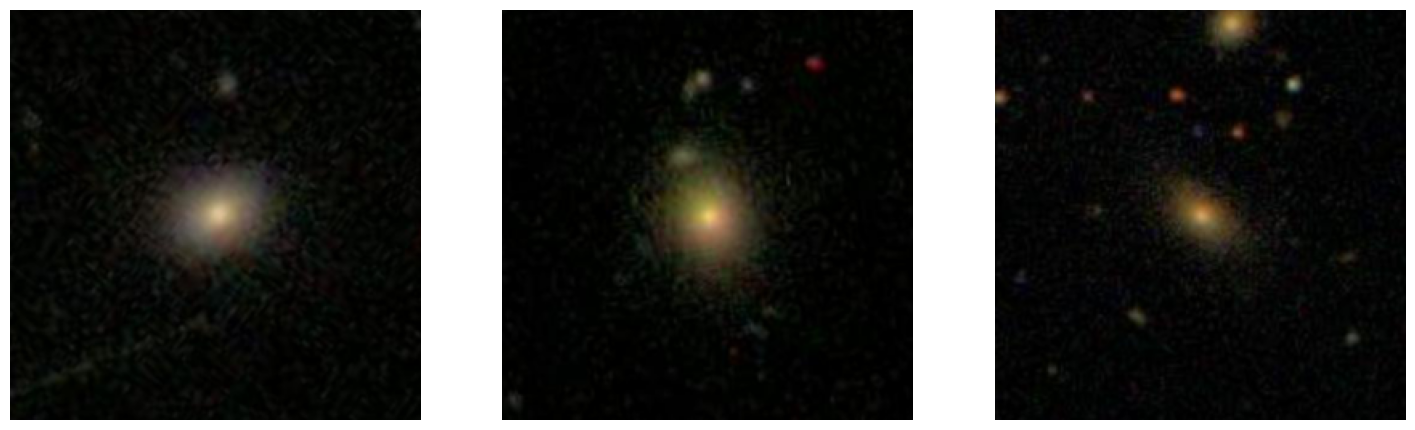

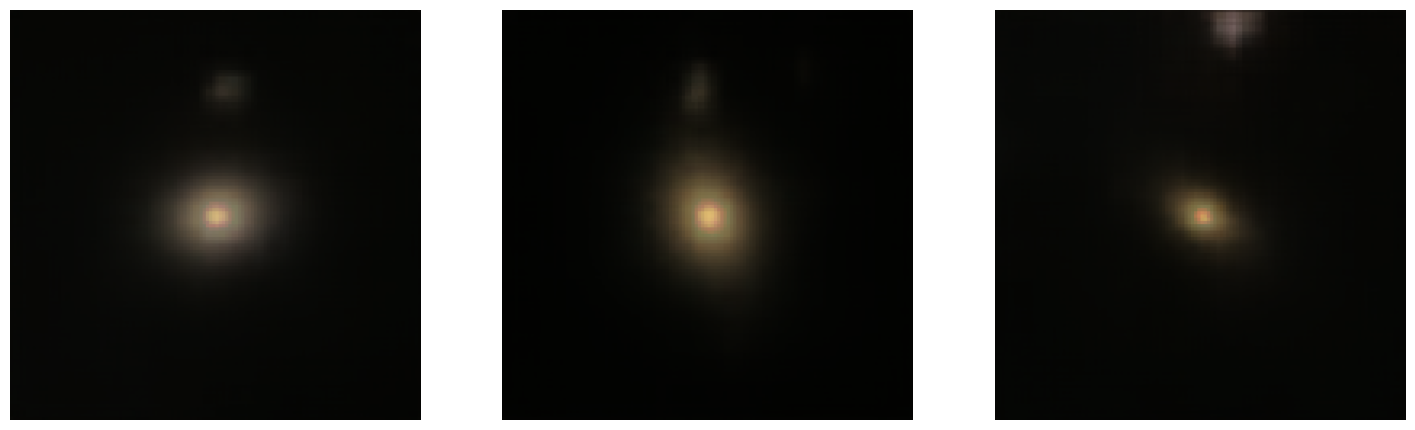

In [0]:
# Larger pictures
print("Reconstruction for Training Data (Above are true images and below are recostructed images)")
vae.eval()
with torch.no_grad():
    for data in train_loader:
        X = data[0].to(device)
        outputs, _, _ = vae(X, Train=False)
        show_img(X.cpu()[:3], img_per_row=3)
        show_img(outputs.cpu()[:3], img_per_row=3)

        break

Reconstruction for Training Data (Above are true images and below are recostructed images)


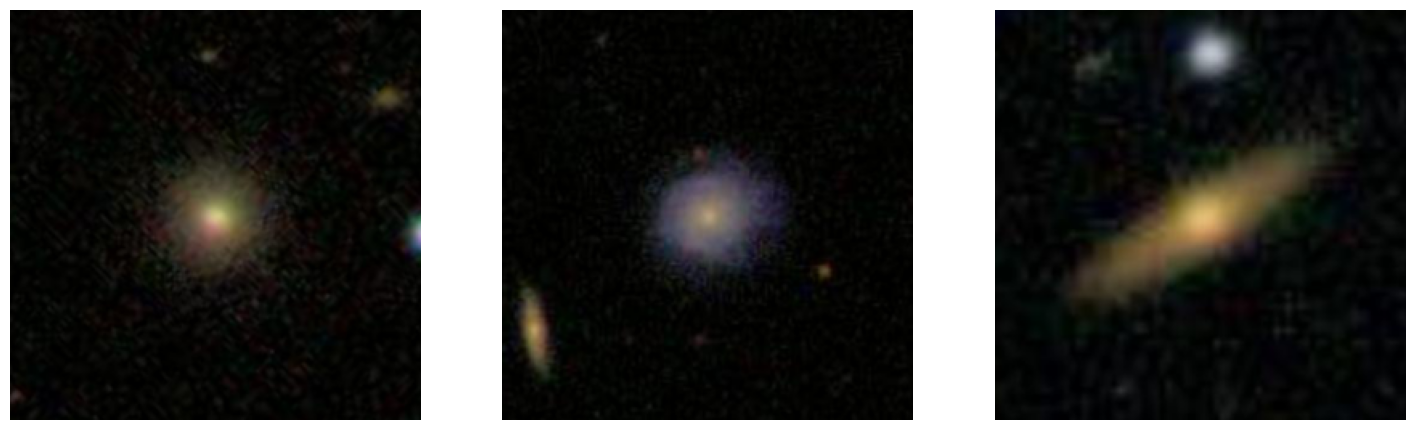

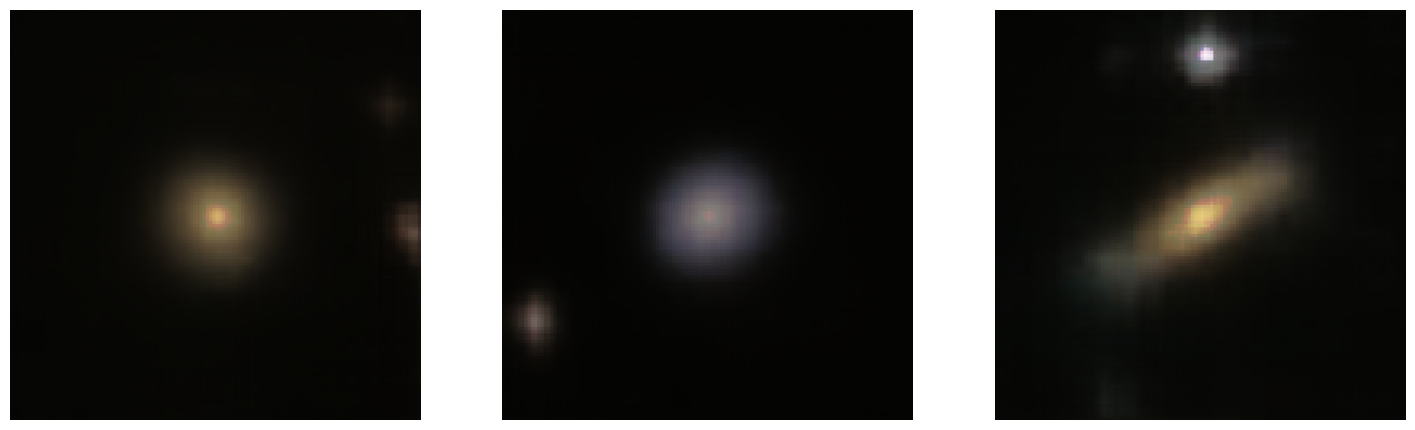

In [0]:
# Larger pictures
print("Reconstruction for Training Data (Above are true images and below are recostructed images)")
vae.eval()
with torch.no_grad():
    for data in train_loader:
        X = data[0].to(device)
        outputs, _, _ = vae(X, Train=False)
        show_img(X.cpu()[:3], img_per_row=3)
        show_img(outputs.cpu()[:3], img_per_row=3)

        break

#### 1.3.3.5 Save Model

In [0]:
torch.save(vae.state_dict(), "/content/drive/My Drive/VAE/best_RES_VAE.pt")